# Library imports

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyomo.environ import *
from pyomo.dae import *

from scipy.integrate import odeint, solve_ivp
from scipy.interpolate import CubicSpline
from sklearn.metrics import r2_score

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# Helper functions

In [2]:
# This simulates the ground truth model detailed in the methods section.
# The physics and assumptions of this model are detailed in the paper

def combined_ode_system(t,y,y0_g):
    
    Xv, Xd, Cg, Cm, Cc = y
    
    mu_g_max = ((0.74)* 10**-0.75)
    Kg = (0.2)* 10**2
    
    mu_c_death = (0.06)* 10**0.25
    Kc = (1)* 10**1.5
    
    k_d = (0.001)* 10**1
    
    Y_xg = (0.052)* 10**0
    
    m_k = (0.06)* 10**-2
    k_c_maint = (0.03)* 10**0    
    
    Y_mx = (20)* 10**-1
    beta = (5)* 10**-0.75
    
    kc = 10**1.5
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    mu_g = 2*((mu_g_max*Cg)/(Kg + Cg))
    
    Xm = Y_xg*y0_g
    
    log_x = (1-(Xv/Xm))
    
    mu_growth = mu_g*log_x
    
    mu_death = k_d + ((mu_c_death*Cc)/(Kc + Cc))/2
    
    maint_gc = (m_k*Cc)/(k_c_maint + Cc)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~    
    dXvdt = (mu_growth - mu_death)*Xv 
    
    dXddt = mu_death*Xv
    
    dCgdt = -1*(mu_growth/Y_xg)*Xv - maint_gc*Xv
    
    dCmdt = Y_mx*(mu_growth + beta)*Xv*(Cc/(Cc + kc))
    
    dCcdt = -1*dCmdt
    
    return [dXvdt, dXddt, dCgdt, dCmdt, dCcdt]

In [3]:
y0 = np.array([0.1, 0.0, 82, 0, 20])
tspan = (0, 72)

sol = solve_ivp(combined_ode_system, tspan, y0, args = tuple([y0[2]]), method = "Radau")

y_true = np.copy(sol.y)

y_act = sol.y
y_act[0,:] = y_act[0,:] + y_act[1,:]
y_act1 = np.delete(y_act, 1, axis = 0)

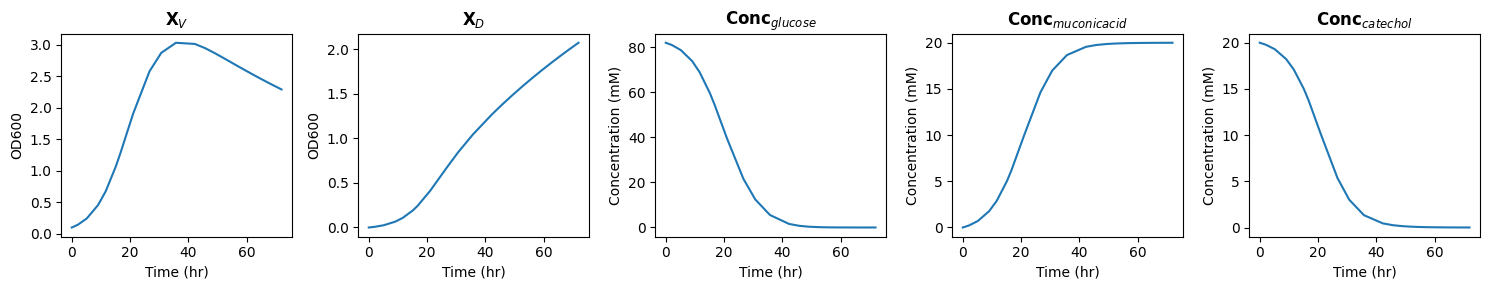

In [4]:
fig, axs = plt.subplots(1,5, figsize = (15,3))
ax = axs.ravel()

Name = ["X$_V$","X$_D$", "Conc$_{glucose}$", "Conc$_{muconic acid}$", "Conc$_{catechol}$"]
ylabels = ["OD600", "OD600", "Concentration (mM)", "Concentration (mM)", "Concentration (mM)"]

for i in range(len(y_true)):
    ax[i].plot(sol.t, y_true[i,:])
    ax[i].set_xlabel("Time (hr)")
    ax[i].set_ylabel(ylabels[i])
    ax[i].set_title(Name[i], fontweight = "bold")

plt.tight_layout()

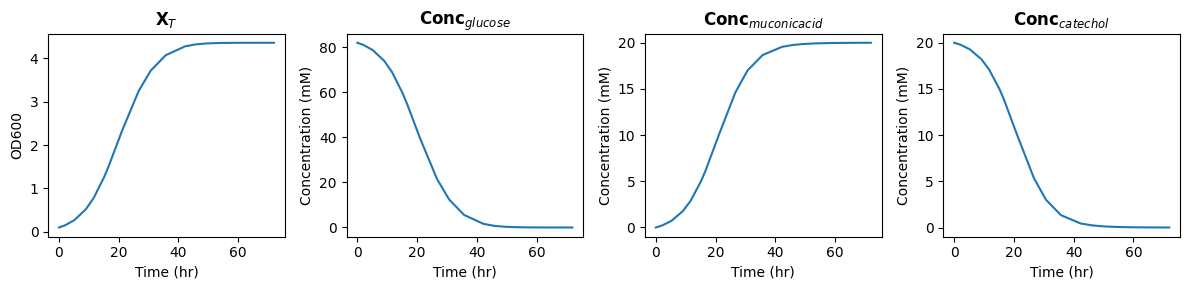

In [5]:
fig, axs = plt.subplots(1, 4, figsize = (12, 3))
ax = axs.ravel()
Name = ["X$_T$", "Conc$_{glucose}$", "Conc$_{muconic acid}$", "Conc$_{catechol}$"]
ylabels = ["OD600", "Concentration (mM)", "Concentration (mM)", "Concentration (mM)"]

for i in range(len(y_act1)):
    ax[i].plot(sol.t, y_act1[i,:])
    ax[i].set_xlabel("Time (hr)")
    ax[i].set_ylabel(ylabels[i])
    ax[i].set_title(Name[i], fontweight = "bold")

plt.tight_layout()

In [6]:
def syn_data_generation(num_points, file_name):
    
    # This function takes in the number point and a file name which has
    # different initial conditions of the batch system. This generates 
    # the training data outlined in the paper. 72-hour batch bioprocess.
    # This return the training data 
    
    dir_n = "Initial_conditions\\" + file_name
    
    Init_cond = np.loadtxt(dir_n)

    sol_dict = {}
    mu_dict = {}

    for i in range(len(Init_cond)):
        
        y0 = Init_cond[i,:]
        tspan = (0, 72)
        teval = np.linspace(tspan[0], tspan[1], num_points)
        
        sol = solve_ivp(combined_ode_system, tspan, y0, args = tuple([y0[2]]), method = "Radau", t_eval = teval)
        
        y_act = sol.y
        y_act[0,:] = y_act[0,:] + y_act[1,:]
        y_act = np.delete(y_act, 1, axis = 0)
        
        sol_dict[i] = y_act
        
        time = sol.t
    
    return [time, sol_dict]

In [7]:
def Error_addition(num_points, file_name, per_err, rs = 10):
    
    # This function adds gaussian noise to the training data
    # This calls the previous function and then adds error to it
    # This function returns the error-added training data
    
    random_seed = rs
    
    time, s_dict = syn_data_generation(num_points, file_name)    
    num_sp, num_t = np.shape(s_dict[0])

    retreived_conc_dict = {}

    for i in range(len(s_dict.keys())):
        
        np.random.seed(random_seed+i)
        D_err = np.random.normal(0,per_err,size = (num_sp, num_t))/100
        
        conc_profiles = s_dict[i]
        D_final = conc_profiles + np.multiply(conc_profiles, D_err)

        retreived_conc_dict[i] = D_final

    
    return [time, retreived_conc_dict]

In [8]:
file_name = "Initial_conditions_3_1_PP.txt"
time, s = syn_data_generation(10, file_name)
t, rc = Error_addition(10,file_name, 10, rs = 5)

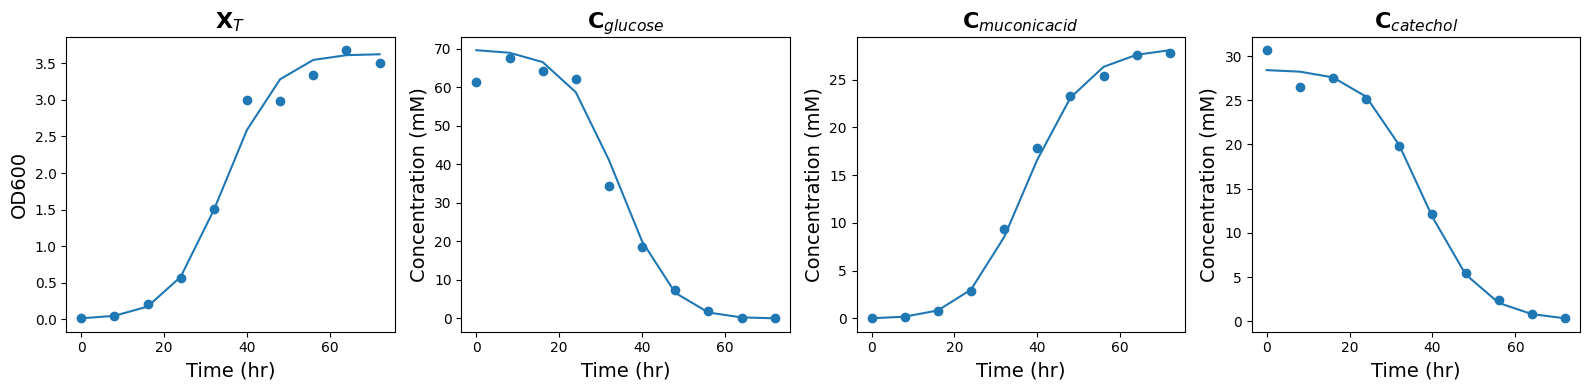

In [9]:
i = 0

fig, axs = plt.subplots(1,4,figsize = (16,4))
ax = axs.ravel()
Name = ["X$_T$", "C$_{glucose}$", "C$_{muconic acid}$", "C$_{catechol}$"]
ylabels = ["OD600", "Concentration (mM)", "Concentration (mM)", "Concentration (mM)"]

for j in range(4):
    ax[j].plot(time, s[i][j])
    ax[j].scatter(t, rc[i][j])
    ax[j].set_xlabel("Time (hr)", fontsize = 14)
    ax[j].set_ylabel(ylabels[j], fontsize = 14)
    ax[j].set_title(Name[j], fontweight = "bold", fontsize = 16)

plt.tight_layout()

# Integrated Model Construction

In [10]:
def ANN_int_mu_model(model,d,t):
    
    # This is the integrated ANN model
    # which will be embedded within the pyomo formulation
    
    Xt = model.conc_Xt[d,t]
    Cg = model.conc_Cg[d,t]
    Cm = model.conc_Cm[d,t]
    Cc = model.conc_Cc[d,t]
    
    h1_list = []
    
    # This calculates the first layer 
    for i in model.h1_num_nod:
        z1 = model.W1[0,i]*Xt + model.W1[1,i]*Cg + model.W1[2,i]*Cm + model.W1[3,i]*Cc + model.b1[i]
        h1 = (1/(1 + math.e**(-1*z1))) #(math.e**(2*z1) - 1)/(math.e**(2*z1) + 1)
        h1_list.append(h1)
    
    z2 = model.b2
    for i in model.h1_num_nod:
        z2 += model.W2[i]*h1_list[i]
    h3 = z2
    
    return h3

In [11]:
def dXtdt_int_con(model, d, t):
    # This captures the ODE dynamic equation for total biomass dynamics
    if t == 0:
        return Constraint.Skip
    mu = ANN_int_mu_model(model,d,t)
    return model.dXtdt[d,t] == mu*model.conc_Xt[d,t]

def dCgdt_int_con(model,d,t):
    # This captures the ODE dynamic equation for glucose concentration dynamics
    if t == 0:
        return Constraint.Skip
    mu = ANN_int_mu_model(model,d,t)
    return model.dCgdt[d,t] == -1*model.conc_Xt[d,t]*(mu*model.Ygx)*(model.max_vals[0]/model.max_vals[1])

def dCmdt_int_con(model,d,t):
    # This capture the ODE dynamic equations for muconic acid concentration dynamics
    if t == 0:
        return Constraint.Skip
    mu = ANN_int_mu_model(model,d,t)
    return model.dCmdt[d,t] == (model.Ymx*mu + model.beta)*model.conc_Xt[d,t]*(
        (model.conc_Cc[d,t])/(model.conc_Cc[d,t] + (model.kc/model.max_vals[3])))*(model.max_vals[0]/model.max_vals[2])

def dCcdt_int_con(model,d,t):
    # This captures the ODE dynamic equations for catechol concentration dynamics
    if t == 0:
        return Constraint.Skip
    return model.dCcdt[d,t] == -1*model.dCmdt[d,t]*(model.max_vals[2]/model.max_vals[3])

def objective_int_SSmse(model):
    # This is a state space objective function for the integrated model
    final = 0
    
    for i in model.d_idx:
        for j in model.t_meas:
            final += (model.conc_Xt_meas[i,j] - model.conc_Xt[i,j])**2
            final += (model.conc_Cg_meas[i,j] - model.conc_Cg[i,j])**2
            final += (model.conc_Cm_meas[i,j] - model.conc_Cm[i,j])**2
            final += (model.conc_Cc_meas[i,j] - model.conc_Cc[i,j])**2
    
    fin = final/(4*len(model.d_idx)*len(model.t_meas))
    
    return fin

In [12]:
def make_model_int_rs_fl(rs, fl):
    
    # This utilizes the above training data generating functions
    # to generate 10-points per initial condition at 10% gaussian noise
    # The initial condition file name and random seed is specified.
    
    num = 10
    err = 10
    rs = rs

    time, s = syn_data_generation(num, fl)
    t, rc = Error_addition(num, fl, err, rs)

    y_temp = []

    for i in range(3):
        y_temp.append(rc[i])

    no_touch_y = np.array(y_temp)
    no_touch_t = np.copy(t)

    n_d, n_s, n_t = np.shape(no_touch_y)

    t = no_touch_t
    y_temp = no_touch_y
    max_vals = np.max(np.max(no_touch_y, axis = 0), axis = 1)

    y_scaled = np.zeros(np.shape(y_temp))
    
    # The training data is converted from numpy files to dictionary
    # This is so that it can be utilized in pyomo formulation

    Xt_dict = {}
    Cg_dict = {}
    Cm_dict = {}
    Cc_dict = {}

    for j in range(n_d):
        for i in range(n_t):
            Xt_dict[(j,t[i])] = y_temp[j,0,i]/max_vals[0]
            y_scaled[j,0,i] = y_temp[j,0,i]/max_vals[0]

            Cg_dict[(j,t[i])] = y_temp[j,1,i]/max_vals[1]
            y_scaled[j,1,i] = y_temp[j,1,i]/max_vals[1]

            Cm_dict[(j,t[i])] = y_temp[j,2,i]/max_vals[2]
            y_scaled[j,2,i] = y_temp[j,2,i]/max_vals[2]

            Cc_dict[(j,t[i])] = y_temp[j,3,i]/max_vals[3]
            y_scaled[j,3,i] = y_temp[j,3,i]/max_vals[3]
            
    ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    # The number of nodes is setup and the following pyomo formulation was generated
    
    num_nodes = 1

    model = ConcreteModel()

    # Sets describing the raw dataset
    model.d_idx = Set(initialize = range(n_d))
    model.t_meas = Set(initialize = no_touch_t)

    # Sets and Param describing integrated ANN structure
    model.h1_num_nod = Set(initialize = range(num_nodes))
    model.num_inputs = Set(initialize = range(n_s))

    # Parameters - State Space data measurment
    model.max_vals = Param(range(4), initialize = max_vals)
    model.conc_Xt_meas = Param(model.d_idx, model.t_meas, initialize = Xt_dict)
    model.conc_Cg_meas = Param(model.d_idx, model.t_meas, initialize = Cg_dict)
    model.conc_Cm_meas = Param(model.d_idx, model.t_meas, initialize = Cm_dict)
    model.conc_Cc_meas = Param(model.d_idx, model.t_meas, initialize = Cc_dict)

    # Variables - Time invariant Parameters
    model.Ygx = Var(within = NonNegativeReals)
    model.Ymx = Var(within = NonNegativeReals)
    model.beta = Var(within = NonNegativeReals)
    model.kc = Var(within = NonNegativeReals)

    # Variables - Concentrations and derivatives
    model.time = ContinuousSet(initialize = model.t_meas, bounds = (0,72))

    model.conc_Xt = Var(model.d_idx, model.time, within = NonNegativeReals)
    model.conc_Cg = Var(model.d_idx, model.time, within = NonNegativeReals)
    model.conc_Cm = Var(model.d_idx, model.time, within = NonNegativeReals)
    model.conc_Cc = Var(model.d_idx, model.time, within = NonNegativeReals)

    model.dXtdt = DerivativeVar(model.conc_Xt, within = Reals)
    model.dCgdt = DerivativeVar(model.conc_Cg, within = Reals)
    model.dCmdt = DerivativeVar(model.conc_Cm, within = Reals)
    model.dCcdt = DerivativeVar(model.conc_Cc, within = Reals)

    # Variables - ANN weights and biases
    model.W1 = Var(model.num_inputs, model.h1_num_nod, bounds = (-1,1))
    model.b1 = Var(model.h1_num_nod, bounds = (-1,1))
    model.W2 = Var(model.h1_num_nod, bounds = (-1,1))
    model.b2 = Var(bounds = (-1,1))

    # Constraints - Hybrid ODEs
    model.deriv_Xt = Constraint(model.d_idx, model.time, rule = dXtdt_int_con)
    model.deriv_Cg = Constraint(model.d_idx, model.time, rule = dCgdt_int_con)
    model.deriv_Cm = Constraint(model.d_idx, model.time, rule = dCmdt_int_con)
    model.deriv_Cc = Constraint(model.d_idx, model.time, rule = dCcdt_int_con)

    # Objective - State space MSE
    model.obj = Objective(expr = objective_int_SSmse)

    # Descritizer for pyomo.dae
    discretizer = TransformationFactory('dae.collocation')

    discretizer.apply_to(model,nfe=n_t,
                         ncp=2,
                         scheme='LAGRANGE-RADAU')

    # Solver - multistart
    solver = SolverFactory("multistart")
    results = solver.solve(model,
                           suppress_unbounded_warning = True,
                           iterations = 50)

    print("Solver status:", results.solver.status)
    print("Termination Condition:", results.solver.termination_condition)
    print(value(model.obj))
    
    # This function returns the pyomo formulation model and the max values to perform
    # a max-scaling of the training data and other testing data
    return [max_vals, model]

In [13]:
def TIV_and_ANN_int_params(model):
    
    # This function takes in a integrated pyomo model
    # and it extracts the time invariant parameters and
    # the ANN weights and biases
    
    TIV_params = {}

    TIV_params["Ygx"] = value(model.Ygx)
    TIV_params["Ymx"] = value(model.Ymx)
    TIV_params["beta"] = value(model.beta)
    TIV_params["kc"] = value(model.kc)
    
    ANN_params = {}

    ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    W1 = np.zeros((len(model.num_inputs), len(model.h1_num_nod)))
    b1 = np.zeros((len(model.h1_num_nod),1))
    W2 = np.zeros((len(model.h1_num_nod),1))

    for i in model.num_inputs:
        for j in model.h1_num_nod:
            W1[i,j] = value(model.W1[i,j])

    for i in model.h1_num_nod:
        b1[i] = value(model.b1[i])
        W2[i] = value(model.W2[i])

    ANN_params["W1"] = W1
    ANN_params["b1"] = b1
    ANN_params["W2"] = W2
    ANN_params["b2"] = value(model.b2)
    
    return [TIV_params, ANN_params]

## Integrated model assembly and testing

In [14]:
def ANN_int_growth_model(y, ANN_params):
    
    # This function takes in the Xt, Cg, Cm, Cc inputs
    # along with the weights and biases of the ANN to
    # calculate the total biomass growth rate
    
    Xt, Cg, Cm, Cc = y
    
    W1 = ANN_params["W1"]
    b1 = ANN_params["b1"]
    W2 = ANN_params["W2"]
    b2 = ANN_params["b2"]
    
    h1_list = []
    for i in range(np.shape(b1)[0]):
        z1 = W1[0,i]*Xt + W1[1,i]*Cg + W1[2,i]*Cm + W1[3,i]*Cc + b1[i,0]
        h1 = (1/(1 + math.e**(-1*z1))) #(math.e**(2*z1) - 1)/(math.e**(2*z1) + 1)
        h1_list.append(h1)
    
    z2 = b2
    for i in range(np.shape(W2)[0]):
        z2 += W2[i,0]*h1_list[i]
    h3 = z2
    
    return h3

In [15]:
def Int_HM_ODE(t,y, param_dict, ANN_params, max_vals):
    
    # This is the system of ODE which simulates
    # the hybrid model trained above and returns
    # the gradients of the changing species.
    
    Xt, Cg, Cm, Cc = y
    
    Ygx = param_dict["Ygx"]
    Ymx = param_dict["Ymx"]
    beta = param_dict["beta"]
    kc = param_dict["kc"]
    
    mu = ANN_int_growth_model(y, ANN_params)
    
    dXtdt = mu*Xt
    dCgdt = -1*Xt*(mu*Ygx)*(max_vals[0]/max_vals[1]) 
    dCmdt = (Ymx*mu + beta)*Xt*((Cc)/(Cc + (kc/max_vals[3])))*(max_vals[0]/max_vals[2])
    dCcdt = -1*dCmdt
    
    return [dXtdt, dCgdt, dCmdt, dCcdt]

In [16]:
def Int_HM_Org_model_comparison_time(y0, tdict, adict, max_vals): 
    
    # This function simulates the batch extrapolation scenario for a given
    # initial condtion for the integrated hybrid ODE model. The function returns
    # the R2 value between the integrated hybrid model and the ground truth model
    # for the same initial conditions. 
    
    y0 = y0
    y0_4 = np.delete(y0,1)
    tspan = (0, 200)


    sol_actual = solve_ivp(combined_ode_system, tspan, y0, args = tuple([y0[2]]), 
                           method = "Radau", t_eval = np.linspace(tspan[0],tspan[1],60))
    y_actual = sol_actual.y
    y_actual[0,:] = y_actual[0,:] + y_actual[1,:]
    y_actual = np.delete(y_actual, 1, axis = 0)

    y0_scaled = np.divide(y0_4, max_vals)
    sol_predict = solve_ivp(Int_HM_ODE, tspan, y0_scaled, args = tuple([tdict, adict, max_vals]),
                            method = "Radau", t_eval = np.linspace(tspan[0],tspan[1],60))
    y_predict = np.multiply(sol_predict.y, max_vals.reshape(-1,1))

    r2_list = [] #r2_score(y_actual, y_predict)#[]

    for j in range(4):
        r2_list.append(r2_score(y_actual[j,:], y_predict[j,:]))

    return np.mean(r2_list)

In [17]:
def Int_HM_Org_model_comparison_FB(y0, tdict, adict, max_vals): 
    
    # This function simulates the semi-batch extrapolation scenario for a given
    # initial condtion for the integrated hybrid ODE model. The semi-batch has
    # a spike input of glucose and catechol of 10 mM and 3 mM respectively every 25 hrs.
    # The function returns the R2 value between the integrated hybrid model and the ground truth model
    # for the same initial conditions. 
    
    y0 = y0
    y0_4 = np.delete(y0,1)
    tspan = (0, 200)

    sol_list = []
    t_init = 0
    t_fin = 25
    count = 0
    y0_org = y0[2]
    
    while t_fin <= tspan[-1]:
        sol_actual = solve_ivp(combined_ode_system, (t_init, t_fin), y0, args = tuple([y0_org + 10*count]), 
                           method = "Radau", t_eval = np.linspace(t_init,t_fin,10))

        sol_list.append(sol_actual)

        y0 = np.copy(sol_actual.y[:,-1])
        y0[2] += 10
        y0[-1] += 3

        t_init += 25
        t_fin += 25

    y = np.zeros((5,80))
    t = []
    for i in range(len(sol_list)):
        s = 10*i
        e = 10*(i+1)
        y[:,s:e] = sol_list[i].y
        t.append(sol_list[i].t)
    t_actual = np.array(t).reshape(-1,)

    y_actual = np.copy(y)
    y_actual[0,:] = y_actual[0,:] + y_actual[1,:]
    y_actual = np.delete(y_actual, 1, axis = 0)



    sol_list = []
    t_init = 0
    t_fin = 25

    y_predict = np.zeros((4,80))
    t = []
    c = 0

    while t_fin <= tspan[-1]:

        y0_scaled = np.divide(y0_4, max_vals)
        sol_predict = solve_ivp(Int_HM_ODE, (t_init, t_fin), y0_scaled, args = tuple([tdict, adict, max_vals]), 
                                method = "Radau", t_eval = np.linspace(t_init,t_fin,10))
        y_pr = np.multiply(sol_predict.y, max_vals.reshape(-1,1))

        y_predict[:,10*c:10*(c+1)] = np.copy(y_pr)
        t.append(np.copy(sol_predict.t))

        y0_4 = np.copy(y_pr[:,-1])
        y0_4[1] += 10
        y0_4[-1] += 3

        t_init += 25
        t_fin += 25
        c += 1

    t_predict = np.array(t).reshape(-1,1)
    
    r2_list = []

    for j in range(4):
        r2_list.append(r2_score(y_actual[j,:], y_predict[j,:]))

    return np.mean(r2_list)

In [18]:
# This generates a list of initial conditions to test the 
# the batch and semi-batch extrapolation of the integrated
# hybrid model. 

Cg_range = np.linspace(20, 100, 30)
Cc_range = np.linspace(5, 55, 30)

Xv_const = 0.01

rect1_cg_cc = []

for i in range(30):
    for j in range(30):
        rect1_cg_cc.append(np.array([Xv_const, 0, Cg_range[i], 0, Cc_range[j]]))

In [19]:
performance_dict = {}

In [20]:
# For different initial conditions and random seeds i.e traing data
# the batch and semi-batch extrapolation is tested and then stored 
# in dictionary

random_seed_list = [5, 10, 15, 20, 25]
file_list = ["Initial_conditions_3_1_PP.txt",
            "Initial_conditions_3_2_PP.txt",
            "Initial_conditions_3_3_PP.txt",
            "Initial_conditions_3_4_PP.txt",
            "Initial_conditions_3_5_PP.txt"]

for fl in range(len(file_list)):
    
    print(file_list[fl])
    perf_dict = {}
    
    for rs in range(len(random_seed_list)):
        
        try:
            max_vals, model_rs1 = make_model_int_rs_fl(random_seed_list[rs], file_list[fl])
        except ValueError:
            print("except")
            max_vals, model_rs1 = make_model_int_rs_fl(random_seed_list[rs]+1, file_list[fl])

        tdict, adict = TIV_and_ANN_int_params(model_rs1)

        rect_T_EX = []
        rect_FB_EX = []

        for i in range(900):
            rect_T_EX.append(Int_HM_Org_model_comparison_time(rect1_cg_cc[i], tdict, adict, max_vals))
            rect_FB_EX.append(Int_HM_Org_model_comparison_FB(rect1_cg_cc[i], tdict, adict, max_vals))

        perf_dict[random_seed_list[rs]] = [rect_T_EX, rect_FB_EX]
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

    performance_dict[file_list[fl]] = perf_dict
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

Initial_conditions_3_1_PP.txt
Solver status: ok
Termination Condition: optimal
0.0022610728205697526
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Solver status: ok
Termination Condition: optimal
0.0017248921426332162
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Solver status: ok
Termination Condition: optimal
0.0023019268245503175
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Solver status: ok
Termination Condition: optimal
0.002697239122331566
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Solver status: ok
Termination Condition: optimal
0.0030454308180718637
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Initial_conditions_3_2_PP.txt
Solver status: ok
Termination Condition: optimal
0.002158283648696355
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Solver status: ok
Termination Condition: optimal
0.0016889967183362658
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Solver status: ok
Termination Condition: optimal
0.0025849000404298715
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Solver status: ok
Termination Condition: optimal
0

In [21]:
# This finds the average performance of the batch and
# semi-batch extrapolation for different initial conditions
# and random seed scenarios.

T_EX = []
FB_EX = []


for i in file_list:
    for j in random_seed_list:
        T_EX.append(performance_dict[i][j][0])
        FB_EX.append(performance_dict[i][j][1])

T_EX = np.array(T_EX)
FB_EX = np.array(FB_EX)

for i in range(np.shape(T_EX)[0]):
    for j in range(np.shape(T_EX)[1]):
        if T_EX[i,j] < 0:
            T_EX[i,j] = 0
        
        if FB_EX[i,j] < 0:
            FB_EX[i,j] = 0

T_EX = np.mean(np.array(T_EX), axis = 0)
FB_EX = np.mean(np.array(FB_EX), axis = 0)

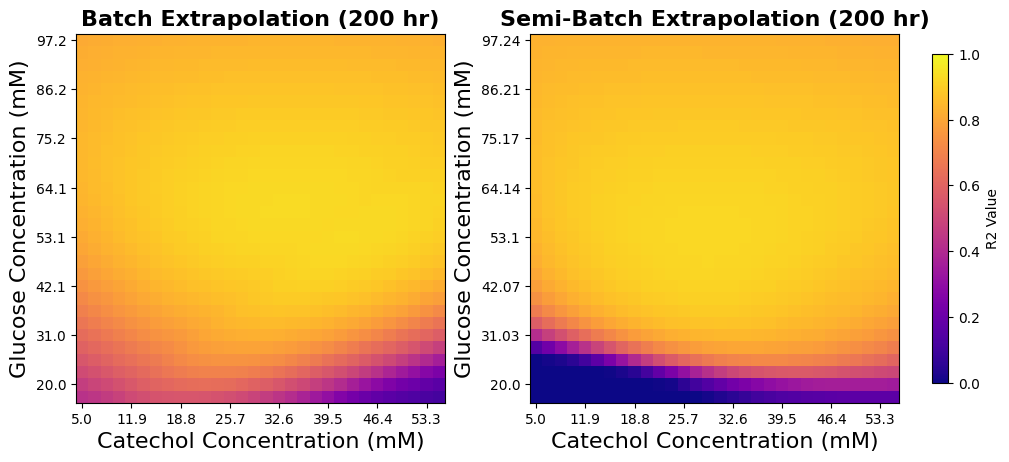

In [22]:
# The data made in the previous box
data1 = np.flipud(np.array(T_EX).reshape(30,30))
data2 = np.flipud(np.array(FB_EX).reshape(30,30))
cmap = "plasma"

# Create a figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)

# Set a common color scale
vmin = 0
vmax = 1

# Create heatmaps
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
im1 = axes[0].imshow(data1, cmap= cmap, vmin=vmin, vmax=vmax)
x_label = []
for i in Cc_range[::4]:
    x_label.append(round(i,1))
y_label = []
for i in np.flipud(Cg_range[::4]):
    y_label.append(round(i,1))
axes[0].set_xticks(ticks = np.arange(30)[::4], labels = x_label)
axes[0].set_yticks(ticks = np.arange(30)[::4], labels = y_label)
axes[0].set_xlabel("Catechol Concentration (mM)", fontsize = 16)
axes[0].set_ylabel("Glucose Concentration (mM)", fontsize = 16)
axes[0].set_title("Batch Extrapolation (200 hr)", fontsize = 16, fontweight = "bold")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
im2 = axes[1].imshow(data2, cmap= cmap, vmin=vmin, vmax=vmax)
x_label = []
for i in Cc_range[::4]:
    x_label.append(round(i,1))
y_label = []
for i in np.flipud(Cg_range[::4]):
    y_label.append(round(i,2))
axes[1].set_xticks(ticks = np.arange(30)[::4], labels = x_label)
axes[1].set_yticks(ticks = np.arange(30)[::4], labels = y_label)
axes[1].set_xlabel("Catechol Concentration (mM)", fontsize = 16)
axes[1].set_ylabel("Glucose Concentration (mM)", fontsize = 16)
axes[1].set_title("Semi-Batch Extrapolation (200 hr)", fontsize = 16, fontweight = "bold")
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Add a common color bar
cbar = fig.colorbar(im1, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('R2 Value')

In [23]:
final_dict = {}
final_dict["HMI_Extrapolation"] = np.array([T_EX, FB_EX])

# Improved hybrid model construction

The model training for the improved model was deconvoluated into two steps:
1) The time invaraint parameter estimation as the underlying phenom model 

2) The second time variant and ANN model training as the overarching hybrid model

The two step process was only possible because the incorporated physics would allow for the first step to occur accurately

## Step 1 - underlying PM construction

In [24]:
def dXtdt_PM_con(model, d, t):
    # This captures the ODE dynamic equation for total biomass dynamics
    if t == 0:
        return Constraint.Skip
    mu = ((model.mu_g*model.conc_Cg[d,t])/(model.conc_Cg[d,t] + (model.kg/model.max_vals[1])))
    return model.dXtdt[d,t] == mu*model.conc_Xt[d,t]

def dCgdt_PM_con(model,d,t):
    # This captures the ODE dynamic equation for glucose concentration dynamics
    if t == 0:
        return Constraint.Skip
    mu = ((model.mu_g*model.conc_Cg[d,t])/(model.conc_Cg[d,t] + (model.kg/model.max_vals[1])))
    return model.dCgdt[d,t] == -1*model.conc_Xt[d,t]*(mu*model.Ygx)*(model.max_vals[0]/model.max_vals[1])

def dCmdt_PM_con(model,d,t):
    # This captures the ODE dynamic equation for muconic acid concentration dynamics
    if t == 0:
        return Constraint.Skip
    mu = ((model.mu_g*model.conc_Cg[d,t])/(model.conc_Cg[d,t] + (model.kg/model.max_vals[1])))
    return model.dCmdt[d,t] == (model.Ymx*mu + model.beta)*model.conc_Xt[d,t]*(
        (model.conc_Cc[d,t])/(model.conc_Cc[d,t] + (model.kc/model.max_vals[3])))*(model.max_vals[0]/model.max_vals[2])

def dCcdt_PM_con(model,d,t):
    # This captures the ODE dynamic equation for catechol concentration dynamics
    if t == 0:
        return Constraint.Skip
    return model.dCcdt[d,t] == -1*model.dCmdt[d,t]*(model.max_vals[2]/model.max_vals[3])

def objective_PM_SSmse(model):
    # This is a state space objective function for the phenomenological model
    final = 0
    
    for i in model.d_idx:
        for j in model.t_meas:
            final += (model.conc_Xt_meas[i,j] - model.conc_Xt[i,j])**2
            final += (model.conc_Cg_meas[i,j] - model.conc_Cg[i,j])**2
            final += (model.conc_Cm_meas[i,j] - model.conc_Cm[i,j])**2
            final += (model.conc_Cc_meas[i,j] - model.conc_Cc[i,j])**2
    
    fin = final/(4*len(model.d_idx)*len(model.t_meas))
    
    return fin

In [25]:
def make_PM_model_rs_fl(rs, fl):
    
    # This utilizes the above training data generating functions
    # to generate 10-points per initial condition at 10% gaussian noise
    # The initial condition file name and random seed is specified.
    
    num = 10
    err = 10
    rs = rs

    time, s = syn_data_generation(num, fl)
    t, rc = Error_addition(num, fl, err, rs)

    y_temp = []

    for i in range(3):
        y_temp.append(rc[i])

    no_touch_y = np.array(y_temp)
    no_touch_t = np.copy(t)

    n_d, n_s, n_t = np.shape(no_touch_y)

    t = no_touch_t
    y_temp = no_touch_y
    max_vals = np.max(np.max(no_touch_y, axis = 0), axis = 1)

    y_scaled = np.zeros(np.shape(y_temp))

    # The training data is converted from numpy files to dictionary
    # This is so that it can be utilized in pyomo formulation
    
    Xt_dict = {}
    Cg_dict = {}
    Cm_dict = {}
    Cc_dict = {}

    for j in range(n_d):
        for i in range(n_t):
            Xt_dict[(j,t[i])] = y_temp[j,0,i]/max_vals[0]
            y_scaled[j,0,i] = y_temp[j,0,i]/max_vals[0]

            Cg_dict[(j,t[i])] = y_temp[j,1,i]/max_vals[1]
            y_scaled[j,1,i] = y_temp[j,1,i]/max_vals[1]

            Cm_dict[(j,t[i])] = y_temp[j,2,i]/max_vals[2]
            y_scaled[j,2,i] = y_temp[j,2,i]/max_vals[2]

            Cc_dict[(j,t[i])] = y_temp[j,3,i]/max_vals[3]
            y_scaled[j,3,i] = y_temp[j,3,i]/max_vals[3]
            
    ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    num_nodes = 1

    model = ConcreteModel()

    # Sets describing the raw dataset
    model.d_idx = Set(initialize = range(n_d))
    model.t_meas = Set(initialize = no_touch_t)

    # Parameters - State Space data measurment
    model.max_vals = Param(range(4), initialize = max_vals)
    model.conc_Xt_meas = Param(model.d_idx, model.t_meas, initialize = Xt_dict)
    model.conc_Cg_meas = Param(model.d_idx, model.t_meas, initialize = Cg_dict)
    model.conc_Cm_meas = Param(model.d_idx, model.t_meas, initialize = Cm_dict)
    model.conc_Cc_meas = Param(model.d_idx, model.t_meas, initialize = Cc_dict)

    # Variables - Time invariant Parameters
    model.mu_g = Var(within = NonNegativeReals)
    model.kg = Var(within = NonNegativeReals)
    model.Ygx = Var(within = NonNegativeReals)
    model.Ymx = Var(within = NonNegativeReals)
    model.beta = Var(within = NonNegativeReals)
    model.kc = Var(within = NonNegativeReals)

    # Variables - Concentrations and derivatives
    model.time = ContinuousSet(initialize = model.t_meas, bounds = (0,72))

    model.conc_Xt = Var(model.d_idx, model.time, within = NonNegativeReals)
    model.conc_Cg = Var(model.d_idx, model.time, within = NonNegativeReals)
    model.conc_Cm = Var(model.d_idx, model.time, within = NonNegativeReals)
    model.conc_Cc = Var(model.d_idx, model.time, within = NonNegativeReals)

    model.dXtdt = DerivativeVar(model.conc_Xt, within = Reals)
    model.dCgdt = DerivativeVar(model.conc_Cg, within = Reals)
    model.dCmdt = DerivativeVar(model.conc_Cm, within = Reals)
    model.dCcdt = DerivativeVar(model.conc_Cc, within = Reals)

    # Constraints - Hybrid ODEs
    model.deriv_Xt = Constraint(model.d_idx, model.time, rule = dXtdt_PM_con)
    model.deriv_Cg = Constraint(model.d_idx, model.time, rule = dCgdt_PM_con)
    model.deriv_Cm = Constraint(model.d_idx, model.time, rule = dCmdt_PM_con)
    model.deriv_Cc = Constraint(model.d_idx, model.time, rule = dCcdt_PM_con)

    # Objective - State space MSE
    model.obj = Objective(expr = objective_PM_SSmse)

    # Descritizer for pyomo.dae
    discretizer = TransformationFactory('dae.collocation')

    discretizer.apply_to(model,nfe=n_t,
                         ncp=2,
                         scheme='LAGRANGE-RADAU')

    # Solver - multistart
    try:
        solver = SolverFactory("multistart")
        results = solver.solve(model,
                               suppress_unbounded_warning = True,
                               iterations = 50)
    except:
        solver = SolverFactory("multistart")
        results = solver.solve(model, 
                              suppress_unbounded_warning = True)

    print("Solver status:", results.solver.status)
    print("Termination Condition:", results.solver.termination_condition)
    print(value(model.obj))
    
    return [max_vals, model]

In [26]:
def PM_TIV_params(model):

    # This function takes in a phenomenological pyomo model
    # and it extracts the time invariant parameters
    
    TIV_params = {}
    
    TIV_params["mu_g"] = value(model.mu_g)
    TIV_params["kg"] = value(model.kg)
    TIV_params["Ygx"] = value(model.Ygx)
    TIV_params["Ymx"] = value(model.Ymx)
    TIV_params["beta"] = value(model.beta)
    TIV_params["kc"] = value(model.kc)
    
    return TIV_params

## Step 2 - Improved hybrid model construction

In [27]:
def ANN_fv_model(model,d,t):

    # This is the integrated ANN model
    # which will be embedded within the pyomo formulation to model
    # the fraction of viable cells in the biomass
    
    Xt = model.conc_Xt[d,t]
    Cg = model.conc_Cg[d,t]
    Cm = model.conc_Cm[d,t]
    Cc = model.conc_Cc[d,t]
    
    h1_list = []
    for i in model.h1_num_nod:
        z1 = model.W1[0,i]*Xt + model.W1[1,i]*Cg + model.W1[2,i]*Cm + model.W1[3,i]*Cc + model.b1[i]
        h1 = (1/(1 + math.e**(-1*z1))) #(math.e**(2*z1) - 1)/(math.e**(2*z1) + 1)
        h1_list.append(h1)
    
    z2 = model.b2
    for i in model.h1_num_nod:
        z2 += model.W2[i]*h1_list[i]
    h3 = z2
    
    return h3

In [28]:
def dXtdt_HM_con(model, d, t):
    # This captures the ODE dynamic equation for total biomass dynamics
    if t == 0:
        return Constraint.Skip
    fv = ANN_fv_model(model,d,t)
    mu = ((model.mu_g*model.conc_Cg[d,t])/(model.conc_Cg[d,t] + (model.kg/model.max_vals[1])))
    return model.dXtdt[d,t] == mu*fv*model.conc_Xt[d,t]

def dCgdt_HM_con(model,d,t):
    # This captures the ODE dynamic equation for glucose concentration dynamics
    if t == 0:
        return Constraint.Skip
    fv = ANN_fv_model(model,d,t)
    mu = ((model.mu_g*model.conc_Cg[d,t])/(model.conc_Cg[d,t] + (model.kg/model.max_vals[1])))
    return model.dCgdt[d,t] == -1*fv*model.conc_Xt[d,t]*(mu*model.Ygx)*(model.max_vals[0]/model.max_vals[1])

def dCmdt_HM_con(model,d,t):
    # This capture the ODE dynamic equations for muconic acid concentration dynamics
    if t == 0:
        return Constraint.Skip
    fv = ANN_fv_model(model,d,t)
    mu = ((model.mu_g*model.conc_Cg[d,t])/(model.conc_Cg[d,t] + (model.kg/model.max_vals[1])))
    return model.dCmdt[d,t] == (model.Ymx*mu + model.beta)*fv*model.conc_Xt[d,t]*(
        (model.conc_Cc[d,t])/(model.conc_Cc[d,t] + (model.kc/model.max_vals[3])))*(model.max_vals[0]/model.max_vals[2])

def dCcdt_HM_con(model,d,t):
    # This captures the ODE dynamic equations for catechol concentration dynamics
    if t == 0:
        return Constraint.Skip
    return model.dCcdt[d,t] == -1*model.dCmdt[d,t]*(model.max_vals[2]/model.max_vals[3])

def objective_HM_SSmse(model):
    # This is a state space objective function for the integrated hybrid model
    final = 0
    
    for i in model.d_idx:
        for j in model.t_meas:
            final += (model.conc_Xt_meas[i,j] - model.conc_Xt[i,j])**2
            final += (model.conc_Cg_meas[i,j] - model.conc_Cg[i,j])**2
            final += (model.conc_Cm_meas[i,j] - model.conc_Cm[i,j])**2
            final += (model.conc_Cc_meas[i,j] - model.conc_Cc[i,j])**2
    
    fin = final/(4*len(model.d_idx)*len(model.t_meas))
    
    return fin

In [29]:
def make_HM_model_rs_fl(rs, fl, tdict):

    # This utilizes the above training data generating functions
    # to generate 10-points per initial condition at 10% gaussian noise
    # The initial condition file name and random seed is specified.
    
    num = 10
    err = 10
    rs = rs

    time, s = syn_data_generation(num, fl)
    t, rc = Error_addition(num, fl, err, rs)

    y_temp = []

    for i in range(3):
        y_temp.append(rc[i])

    no_touch_y = np.array(y_temp)
    no_touch_t = np.copy(t)

    n_d, n_s, n_t = np.shape(no_touch_y)

    t = no_touch_t
    y_temp = no_touch_y
    max_vals = np.max(np.max(no_touch_y, axis = 0), axis = 1)

    y_scaled = np.zeros(np.shape(y_temp))

    # The training data is converted from numpy files to dictionary
    # This is so that it can be utilized in pyomo formulation
    
    Xt_dict = {}
    Cg_dict = {}
    Cm_dict = {}
    Cc_dict = {}

    for j in range(n_d):
        for i in range(n_t):
            Xt_dict[(j,t[i])] = y_temp[j,0,i]/max_vals[0]
            y_scaled[j,0,i] = y_temp[j,0,i]/max_vals[0]

            Cg_dict[(j,t[i])] = y_temp[j,1,i]/max_vals[1]
            y_scaled[j,1,i] = y_temp[j,1,i]/max_vals[1]

            Cm_dict[(j,t[i])] = y_temp[j,2,i]/max_vals[2]
            y_scaled[j,2,i] = y_temp[j,2,i]/max_vals[2]

            Cc_dict[(j,t[i])] = y_temp[j,3,i]/max_vals[3]
            y_scaled[j,3,i] = y_temp[j,3,i]/max_vals[3]
            
    ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    num_nodes = 1

    model = ConcreteModel()

    # Sets describing the raw dataset
    model.d_idx = Set(initialize = range(n_d))
    model.t_meas = Set(initialize = no_touch_t)

    # Sets and Param describing integrated ANN structure
    model.h1_num_nod = Set(initialize = range(num_nodes))
    model.num_inputs = Set(initialize = range(n_s))

    # Parameters - State Space data measurment
    model.max_vals = Param(range(4), initialize = max_vals)
    model.conc_Xt_meas = Param(model.d_idx, model.t_meas, initialize = Xt_dict)
    model.conc_Cg_meas = Param(model.d_idx, model.t_meas, initialize = Cg_dict)
    model.conc_Cm_meas = Param(model.d_idx, model.t_meas, initialize = Cm_dict)
    model.conc_Cc_meas = Param(model.d_idx, model.t_meas, initialize = Cc_dict)

    # Variables - Time invariant Parameters
    model.mu_g = Param(initialize = tdict["mu_g"])
    model.kg = Param(initialize = tdict["kg"])
    model.Ygx = Param(initialize = tdict["Ygx"])
    model.Ymx = Param(initialize = tdict["Ymx"])
    model.beta = Param(initialize = tdict["beta"])
    model.kc = Param(initialize = tdict["kc"])

    # Variables - Concentrations and derivatives
    model.time = ContinuousSet(initialize = model.t_meas, bounds = (0,72))

    model.conc_Xt = Var(model.d_idx, model.time, within = NonNegativeReals)
    model.conc_Cg = Var(model.d_idx, model.time, within = NonNegativeReals)
    model.conc_Cm = Var(model.d_idx, model.time, within = NonNegativeReals)
    model.conc_Cc = Var(model.d_idx, model.time, within = NonNegativeReals)

    model.dXtdt = DerivativeVar(model.conc_Xt, within = Reals)
    model.dCgdt = DerivativeVar(model.conc_Cg, within = Reals)
    model.dCmdt = DerivativeVar(model.conc_Cm, within = Reals)
    model.dCcdt = DerivativeVar(model.conc_Cc, within = Reals)

    # Variables - ANN weights and biases
    model.W1 = Var(model.num_inputs, model.h1_num_nod, bounds = (-1,1))
    model.b1 = Var(model.h1_num_nod, bounds = (-1,1))
    model.W2 = Var(model.h1_num_nod, bounds = (-1,1))
    model.b2 = Var(bounds = (-1,1))

    # Constraints - Hybrid ODEs
    model.deriv_Xt = Constraint(model.d_idx, model.time, rule = dXtdt_HM_con)
    model.deriv_Cg = Constraint(model.d_idx, model.time, rule = dCgdt_HM_con)
    model.deriv_Cm = Constraint(model.d_idx, model.time, rule = dCmdt_HM_con)
    model.deriv_Cc = Constraint(model.d_idx, model.time, rule = dCcdt_HM_con)

    # Objective - State space MSE
    model.obj = Objective(expr = objective_HM_SSmse)

    # Descritizer for pyomo.dae
    discretizer = TransformationFactory('dae.collocation')

    discretizer.apply_to(model,nfe=n_t,
                         ncp=2,
                         scheme='LAGRANGE-RADAU')

    # Solver - multistart
    try:
        solver = SolverFactory("multistart")
        results = solver.solve(model,
                               suppress_unbounded_warning = True,
                               iterations = 50)
    except:
        solver = SolverFactory("multistart")
        results = solver.solve(model, 
                              suppress_unbounded_warning = True)

    print("Solver status:", results.solver.status)
    print("Termination Condition:", results.solver.termination_condition)
    print(value(model.obj))
    
    return [max_vals, model]

In [30]:
def TIV_and_ANN_ImHMI_params(model):
    
    # This function takes in a integrated pyomo model
    # and it extracts the time invariant parameters and
    # the ANN weights and biases
    
    TIV_params = {}
    
    TIV_params["mu_g"] = value(model.mu_g)
    TIV_params["kg"] = value(model.kg)
    TIV_params["Ygx"] = value(model.Ygx)
    TIV_params["Ymx"] = value(model.Ymx)
    TIV_params["beta"] = value(model.beta)
    TIV_params["kc"] = value(model.kc)
    
    ANN_params = {}

    ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    W1 = np.zeros((len(model.num_inputs), len(model.h1_num_nod)))
    b1 = np.zeros((len(model.h1_num_nod),1))
    W2 = np.zeros((len(model.h1_num_nod),1))

    for i in model.num_inputs:
        for j in model.h1_num_nod:
            W1[i,j] = value(model.W1[i,j])

    for i in model.h1_num_nod:
        b1[i] = value(model.b1[i])
        W2[i] = value(model.W2[i])

    ANN_params["W1"] = W1
    ANN_params["b1"] = b1
    ANN_params["W2"] = W2
    ANN_params["b2"] = value(model.b2)
    
    return [TIV_params, ANN_params]

## Improved hybrid model assembly and testing

In [31]:
def ANN_frac_via_model(y, ANN_params):
    
    # This function takes in the Xt, Cg, Cm, Cc inputs
    # along with the weights and biases of the ANN to
    # calculate the fraction of viable biomass
    
    Xt, Cg, Cm, Cc = y
    
    W1 = ANN_params["W1"]
    b1 = ANN_params["b1"]
    W2 = ANN_params["W2"]
    b2 = ANN_params["b2"]
    
    h1_list = []
    for i in range(np.shape(b1)[0]):
        z1 = W1[0,i]*Xt + W1[1,i]*Cg + W1[2,i]*Cm + W1[3,i]*Cc + b1[i,0]
        h1 = (1/(1 + math.e**(-1*z1))) #(math.e**(2*z1) - 1)/(math.e**(2*z1) + 1)
        h1_list.append(h1)
    
    z2 = b2
    for i in range(np.shape(W2)[0]):
        z2 += W2[i,0]*h1_list[i]
    h3 = z2
    
    return h3

In [32]:
def Imp_HM_ODE(t,y, param_dict, ANN_params, max_vals):

    # This is the system of ODE which simulates
    # the improved hybrid model trained above and returns
    # the gradients of the changing species.
    
    Xt, Cg, Cm, Cc = y
    
    mu_g = param_dict["mu_g"]
    kg = param_dict["kg"]
    Ygx = param_dict["Ygx"]
    Ymx = param_dict["Ymx"]
    beta = param_dict["beta"]
    kc = param_dict["kc"]
    
    fv = ANN_frac_via_model(y, ANN_params)
    mu = ((mu_g*Cg)/(Cg + (kg/max_vals[1])))

    dXtdt = mu*fv*Xt
    dCgdt = -1*fv*Xt*(mu*Ygx)*(max_vals[0]/max_vals[1]) 
    dCmdt = (Ymx*mu + beta)*fv*Xt*((Cc)/(Cc + (kc/max_vals[3])))*(max_vals[0]/max_vals[2])
    dCcdt = -1*dCmdt
    
    return [dXtdt, dCgdt, dCmdt, dCcdt]

In [33]:
def Imp_HM_Org_model_comparison_time(y0, tdict, adict, max_vals): 
    
    # This function simulates the batch extrapolation scenario for a given
    # initial condtion for the improved hybrid ODE model. The function returns
    # the R2 value between the improved hybrid model and the ground truth model
    # for the same initial conditions.     
    
    y0 = y0
    y0_4 = np.delete(y0,1)
    tspan = (0, 200)


    sol_actual = solve_ivp(combined_ode_system, tspan, y0, args = tuple([y0[2]]), 
                           method = "Radau", t_eval = np.linspace(tspan[0],tspan[1],60))
    y_actual = sol_actual.y
    y_actual[0,:] = y_actual[0,:] + y_actual[1,:]
    y_actual = np.delete(y_actual, 1, axis = 0)

    y0_scaled = np.divide(y0_4, max_vals)
    sol_predict = solve_ivp(Imp_HM_ODE, tspan, y0_scaled, args = tuple([tdict, adict, max_vals]),
                            method = "Radau", t_eval = np.linspace(tspan[0],tspan[1],60))
    y_predict = np.multiply(sol_predict.y, max_vals.reshape(-1,1))

    r2_list = [] #r2_score(y_actual, y_predict)#[]
    
    try:
        for j in range(4):
            r2_list.append(r2_score(y_actual[j,:], y_predict[j,:]))
    except ValueError:
        r2_list = [0,0,0,0]
    
    return np.mean(r2_list)

In [34]:
def Imp_HM_Org_model_comparison_FB(y0, tdict, adict, max_vals): 
    
    # This function simulates the semi-batch extrapolation scenario for a given
    # initial condtion for the improved hybrid ODE model. The semi-batch has
    # a spike input of glucose and catechol of 10 mM and 3 mM respectively every 25 hrs.
    # The function returns the R2 value between the integrated hybrid model and the ground truth model
    # for the same initial conditions.     
    
    y0 = y0
    y0_4 = np.delete(y0,1)
    tspan = (0, 200)

    sol_list = []
    t_init = 0
    t_fin = 25
    count = 0
    y0_org = y0[2]
    
    while t_fin <= tspan[-1]:
        sol_actual = solve_ivp(combined_ode_system, (t_init, t_fin), y0, args = tuple([y0_org + 10*count]), 
                           method = "Radau", t_eval = np.linspace(t_init,t_fin,10))

        sol_list.append(sol_actual)

        y0 = np.copy(sol_actual.y[:,-1])
        y0[2] += 10
        y0[-1] += 3

        t_init += 25
        t_fin += 25

    y = np.zeros((5,80))
    t = []
    for i in range(len(sol_list)):
        s = 10*i
        e = 10*(i+1)
        y[:,s:e] = sol_list[i].y
        t.append(sol_list[i].t)
    t_actual = np.array(t).reshape(-1,)

    y_actual = np.copy(y)
    y_actual[0,:] = y_actual[0,:] + y_actual[1,:]
    y_actual = np.delete(y_actual, 1, axis = 0)



    sol_list = []
    t_init = 0
    t_fin = 25

    y_predict = np.zeros((4,80))
    t = []
    c = 0

    while t_fin <= tspan[-1]:

        y0_scaled = np.divide(y0_4, max_vals)
        sol_predict = solve_ivp(Imp_HM_ODE, (t_init, t_fin), y0_scaled, args = tuple([tdict, adict, max_vals]), 
                                method = "Radau", t_eval = np.linspace(t_init,t_fin,10))
        y_pr = np.multiply(sol_predict.y, max_vals.reshape(-1,1))

        y_predict[:,10*c:10*(c+1)] = np.copy(y_pr)
        t.append(np.copy(sol_predict.t))

        y0_4 = np.copy(y_pr[:,-1])
        y0_4[1] += 10
        y0_4[-1] += 3

        t_init += 25
        t_fin += 25
        c += 1

    t_predict = np.array(t).reshape(-1,1)
    
    r2_list = []

    for j in range(4):
        r2_list.append(r2_score(y_actual[j,:], y_predict[j,:]))

    return np.mean(r2_list)

In [35]:
# This generates a list of initial conditions to test the 
# the batch and semi-batch extrapolation of the integrated
# hybrid model. 

Cg_range = np.linspace(20, 100, 30)
Cc_range = np.linspace(5, 55, 30)

Xv_const = 0.01

rect1_cg_cc = []

for i in range(30):
    for j in range(30):
        rect1_cg_cc.append(np.array([Xv_const, 0, Cg_range[i], 0, Cc_range[j]]))

In [36]:
# For different initial conditions and random seeds i.e traing data
# the batch and semi-batch extrapolation is tested and then stored 
# in dictionary

random_seed_list = [5, 10, 15, 20, 25]
file_list = ["Initial_conditions_3_1_PP.txt",
            "Initial_conditions_3_2_PP.txt",
            "Initial_conditions_3_3_PP.txt",
            "Initial_conditions_3_4_PP.txt",
            "Initial_conditions_3_5_PP.txt"]
performance_dict = {}


for fl in range(len(file_list)):
    
    print(file_list[fl])
    perf_dict = {}
    
    for rs in range(len(random_seed_list)):
        
        try:
            max_vals1, PM_model_rs1 = make_PM_model_rs_fl(random_seed_list[rs], file_list[fl])
            tdict = PM_TIV_params(PM_model_rs1)
            max_vals, HM_model_rs1 = make_HM_model_rs_fl(random_seed_list[rs], file_list[fl], tdict)
           
        except ValueError:
            print("except")
            max_vals1, PM_model_rs1 = make_PM_model_rs_fl(random_seed_list[rs] + 1, file_list[fl])
            tdict = PM_TIV_params(PM_model_rs1)
            max_vals, HM_model_rs1 = make_HM_model_rs_fl(random_seed_list[rs] + 1, file_list[fl], tdict)
            


        tdict, adict = TIV_and_ANN_ImHMI_params(HM_model_rs1)

        rect_T_EX = []
        rect_FB_EX = []

        for i in range(900):
            rect_T_EX.append(Imp_HM_Org_model_comparison_time(rect1_cg_cc[i], tdict, adict, max_vals))
            rect_FB_EX.append(Imp_HM_Org_model_comparison_FB(rect1_cg_cc[i], tdict, adict, max_vals))

        perf_dict[random_seed_list[rs]] = [rect_T_EX, rect_FB_EX]
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    
    performance_dict[file_list[fl]] = perf_dict
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

Initial_conditions_3_1_PP.txt
Solver status: ok
Termination Condition: optimal
0.0023625329452173433
Solver status: ok
Termination Condition: optimal
0.002321046845120922
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Solver status: ok
Termination Condition: optimal
0.0029933159614905637
Solver status: ok
Termination Condition: optimal
0.0019744300110593606
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Solver status: ok
Termination Condition: optimal
0.002364662212347811
Solver status: ok
Termination Condition: optimal
0.002314988641697495
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Solver status: ok
Termination Condition: optimal
0.0028232883198523137
Solver status: ok
Termination Condition: optimal
0.0027988740748914596
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Solver status: ok
Termination Condition: optimal
0.0031190986146201276
Solver status: ok
Termination Condition: optimal
0.0030866559107326713
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Initial_conditions_3_2_PP.txt
Solver status: ok

In [37]:
# This finds the average performance of the batch and
# semi-batch extrapolation for different initial conditions
# and random seed scenarios.

T_EX = []
FB_EX = []


for i in file_list:
    for j in random_seed_list:
        T_EX.append(performance_dict[i][j][0])
        FB_EX.append(performance_dict[i][j][1])


T_EX = np.array(T_EX)
FB_EX = np.array(FB_EX)

for i in range(np.shape(T_EX)[0]):
    for j in range(np.shape(T_EX)[1]):
        if T_EX[i,j] < 0:
            T_EX[i,j] = 0
        
        if FB_EX[i,j] < 0:
            FB_EX[i,j] = 0

T_EX = np.mean(np.array(T_EX), axis = 0)
FB_EX = np.mean(np.array(FB_EX), axis = 0)

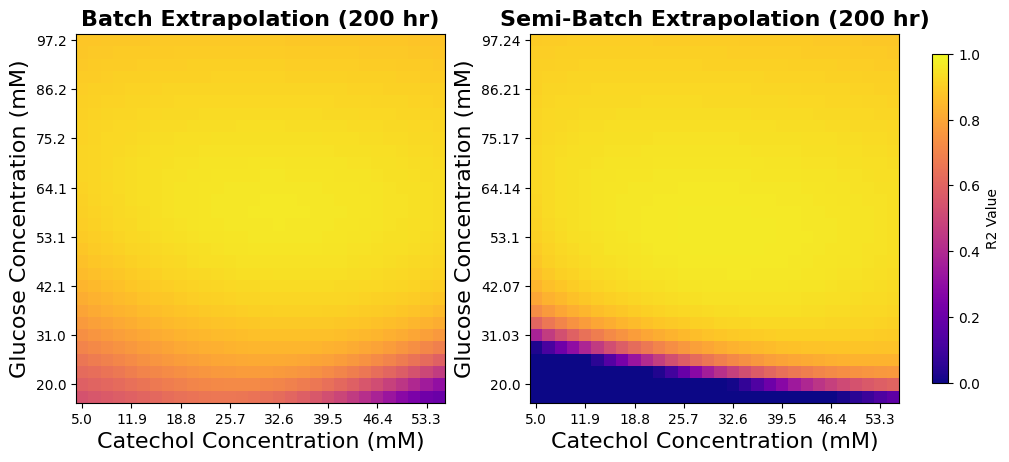

In [38]:
# Generate some example data for the heatmaps
data1 = np.flipud(np.array(T_EX).reshape(30,30))
data2 = np.flipud(np.array(FB_EX).reshape(30,30))
cmap = "plasma"

# Create a figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)

# Set a common color scale
vmin = 0
vmax = 1

# Create heatmaps
im1 = axes[0].imshow(data1, cmap= cmap, vmin=vmin, vmax=vmax)
x_label = []
for i in Cc_range[::4]:
    x_label.append(round(i,1))
y_label = []
for i in np.flipud(Cg_range[::4]):
    y_label.append(round(i,1))
axes[0].set_xticks(ticks = np.arange(30)[::4], labels = x_label)
axes[0].set_yticks(ticks = np.arange(30)[::4], labels = y_label)
axes[0].set_xlabel("Catechol Concentration (mM)", fontsize = 16)
axes[0].set_ylabel("Glucose Concentration (mM)", fontsize = 16)
axes[0].set_title("Batch Extrapolation (200 hr)", fontsize = 16, fontweight = "bold")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

im2 = axes[1].imshow(data2, cmap= cmap, vmin=vmin, vmax=vmax)
x_label = []
for i in Cc_range[::4]:
    x_label.append(round(i,1))
y_label = []
for i in np.flipud(Cg_range[::4]):
    y_label.append(round(i,2))
axes[1].set_xticks(ticks = np.arange(30)[::4], labels = x_label)
axes[1].set_yticks(ticks = np.arange(30)[::4], labels = y_label)
axes[1].set_xlabel("Catechol Concentration (mM)", fontsize = 16)
axes[1].set_ylabel("Glucose Concentration (mM)", fontsize = 16)
axes[1].set_title("Semi-Batch Extrapolation (200 hr)", fontsize = 16, fontweight = "bold")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Add a common color bar
cbar = fig.colorbar(im1, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('R2 Value')

In [39]:
final_dict["ImHMI_Extrapolation"] = np.array([T_EX, FB_EX])

# Final Performance Evaluation

In [40]:
int_list = []
file_list = ["Initial_conditions_3_1_PP.txt",
            "Initial_conditions_3_2_PP.txt",
            "Initial_conditions_3_3_PP.txt",
            "Initial_conditions_3_4_PP.txt",
            "Initial_conditions_3_5_PP.txt"]

for i in file_list:
    fl = "Initial_conditions\\" + i
    int_list.append(np.loadtxt(fl))

In [41]:
a = np.array(int_list)

Cg_min = np.min(a[:,:,2])
Cc_min = np.min(a[:,:,-1])

Cg_max = np.max(a[:,:,2])
Cc_max = np.max(a[:,:,-1])

x_min = (30/50)*(Cc_min - 5)
x_max = (30/50)*(Cc_max - 5)

y_min = (30/80)*(Cg_min - 20)
y_max = (30/80)*(Cg_max - 20)

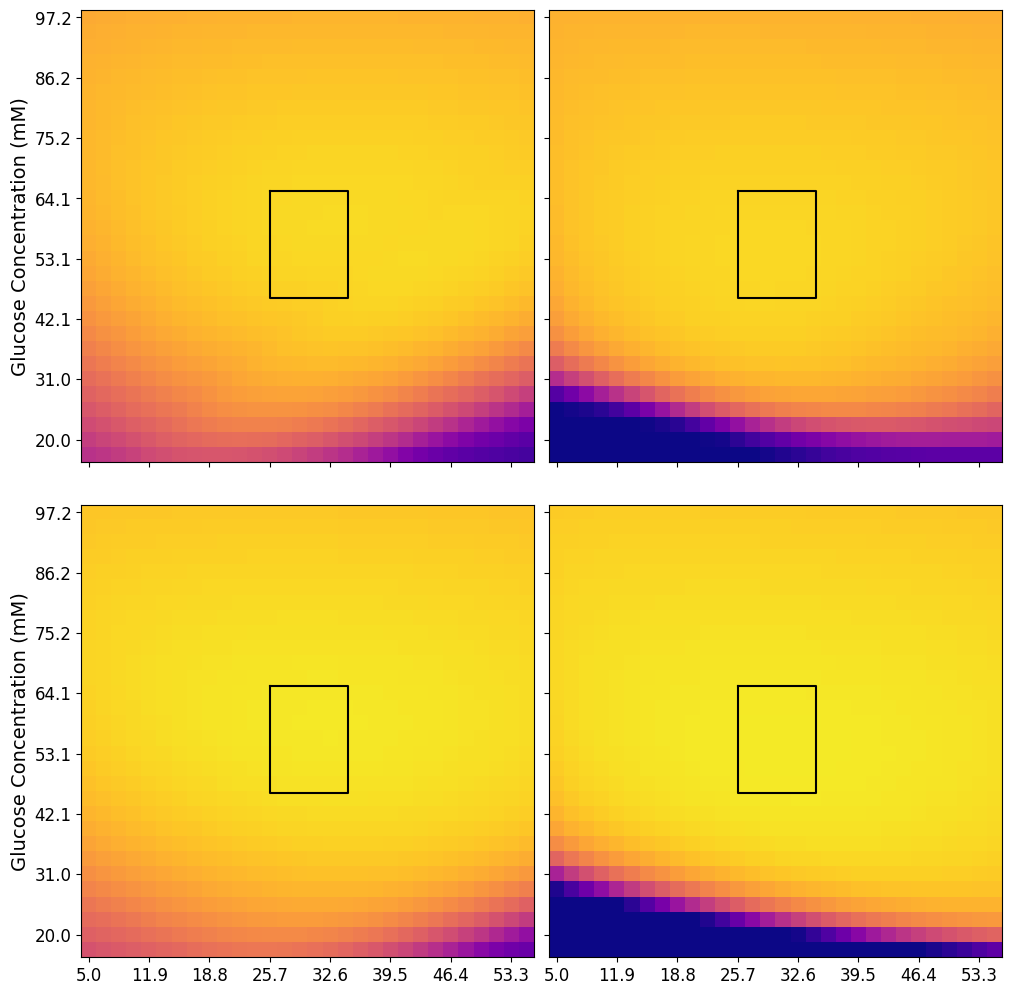

In [43]:
cmap = "plasma"
vmin = 0
vmax = 1
titles = {"HMI_Extrapolation" : "Original Hybrid", "ImHMI_Extrapolation" : "Improved Hybrid"}
keys = list(titles.keys())

Cg_range = np.linspace(20, 100, 30)
Cc_range = np.linspace(5, 55, 30)

Xv_const = 0.01


# Create a figure and subplots
fig, axes = plt.subplots(2, 2, figsize=(10,10), constrained_layout=True, sharex = True, sharey = True)

for z in range(len(keys)):
    data1 =  np.flipud(final_dict[keys[z]][0].reshape(30,30))
    data2 =  np.flipud(final_dict[keys[z]][1].reshape(30,30))

    # Create heatmaps
    im1 = axes[z,0].imshow(data1, cmap= cmap, vmin=vmin, vmax=vmax)
    x_label = []
    for i in Cc_range[::4]:
        x_label.append(round(i,1))
    y_label = []
    for i in np.flipud(Cg_range[::4]):
        y_label.append(round(i,1))
    axes[z,0].set_xticks(ticks = np.arange(30)[::4], labels = x_label, fontsize = 12)
    axes[z,0].set_yticks(ticks = np.arange(30)[::4], labels = y_label, fontsize = 12)
    if z == 2: 
        axes[z,0].set_xlabel("Catechol Concentration (mM)", fontsize = 14)
    axes[z,0].set_ylabel("Glucose Concentration (mM)", fontsize = 14)
    axes[z,0].plot([x_min, x_max, x_max, x_min, x_min],[y_min, y_min, y_max, y_max, y_min ],"k")
    #axes[z,0].set_ylabel(titles[keys[z]], fontsize = 16, fontweight = "bold")

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    im2 = axes[z,1].imshow(data2, cmap= cmap, vmin=vmin, vmax=vmax)
    x_label = []
    for i in Cc_range[::4]:
        x_label.append(round(i,1))
    y_label = []
    for i in np.flipud(Cg_range[::4]):
        y_label.append(round(i,1))
    axes[z,1].set_xticks(ticks = np.arange(30)[::4], labels = x_label, fontsize = 12)
    axes[z,1].set_yticks(ticks = np.arange(30)[::4], labels = y_label, fontsize = 12)
    if z == 2:
        axes[z,1].set_xlabel("Catechol Concentration (mM)", fontsize = 14)
    axes[z,1].plot([x_min, x_max, x_max, x_min, x_min],[y_min, y_min, y_max, y_max, y_min ],"k")

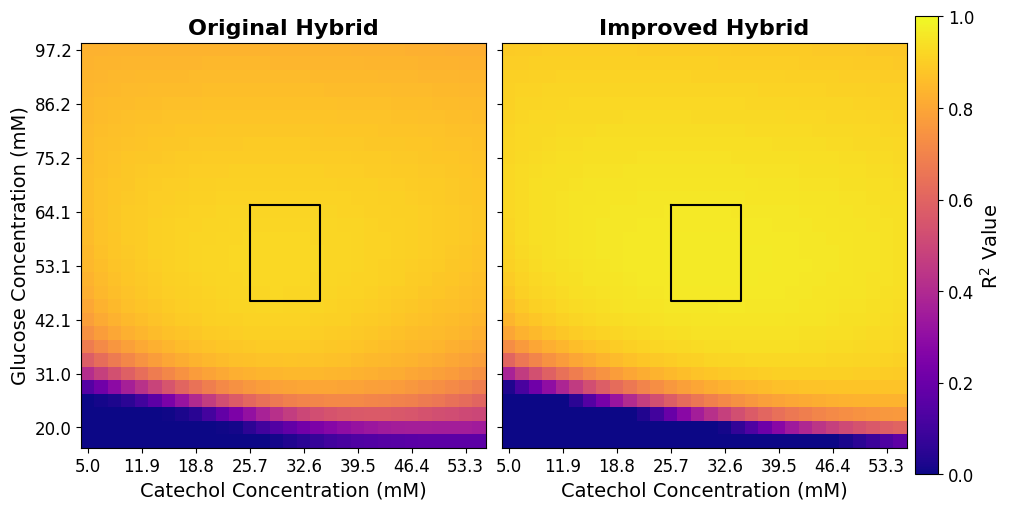

In [50]:
cmap = "plasma"
vmin = 0
vmax = 1
titles = {"HMI_Extrapolation" : "Original Hybrid", "ImHMI_Extrapolation" : "Improved Hybrid"}
keys = list(titles.keys())

Cg_range = np.linspace(20, 100, 30)
Cc_range = np.linspace(5, 55, 30)

Xv_const = 0.01


# Create a figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(10,5), constrained_layout=True, sharex = True, sharey = True)

for z in range(len(keys)):
    data1 =  np.flipud(final_dict[keys[z]][1].reshape(30,30))

    # Create heatmaps
    im1 = axes[z].imshow(data1, cmap= cmap, vmin=vmin, vmax=vmax)
    x_label = []
    for i in Cc_range[::4]:
        x_label.append(round(i,1))
    y_label = []
    for i in np.flipud(Cg_range[::4]):
        y_label.append(round(i,1))
    axes[z].set_xticks(ticks = np.arange(30)[::4], labels = x_label, fontsize = 12)
    axes[z].set_yticks(ticks = np.arange(30)[::4], labels = y_label, fontsize = 12) 
    axes[z].set_xlabel("Catechol Concentration (mM)", fontsize = 14)
    if z == 0:
        axes[z].set_ylabel("Glucose Concentration (mM)", fontsize = 14)
    axes[z].plot([x_min, x_max, x_max, x_min, x_min],[y_min, y_min, y_max, y_max, y_min ],"k")
    axes[z].set_title(titles[keys[z]], fontsize = 16, fontweight = "bold")


    # Add a common color bar
imz = im2
cbar = fig.colorbar(imz, ax=axes, orientation='vertical', fraction=0.07, pad=0.01)
cbar.set_label('R$^2$ Value', fontsize = 14)
cbar.ax.tick_params(labelsize = 12)

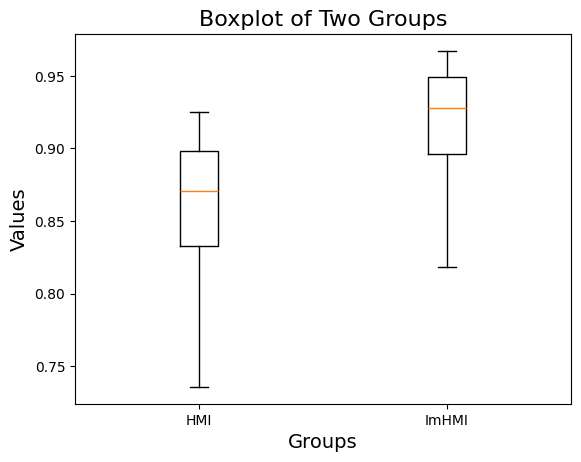

In [51]:
# Generate sample data for two groups
data1 = final_dict["HMI_Extrapolation"][1]  # Group 1 data
data2 = final_dict["ImHMI_Extrapolation"][1]

# Combine data into a list for plotting
data = [data1, data2]

# Create the boxplot
#plt.figure(figsize=(8, 6))  # Set figure size
plt.boxplot(data, labels=['HMI', "ImHMI"], showfliers = False)  # Add labels for the x-axis

# Add axis labels
plt.xlabel('Groups', fontsize=14)
plt.ylabel('Values', fontsize=14)

# Add a title (optional)
plt.title('Boxplot of Two Groups', fontsize=16)

# Show the plot
plt.show()

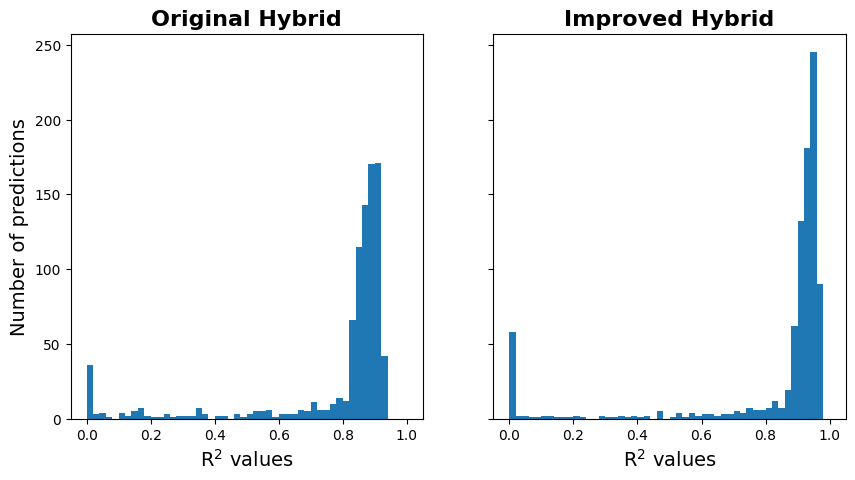

In [52]:
fig, axs = plt.subplots(1,2, figsize = (10,5), sharex = True, sharey = True)
ax = axs.ravel()
n = 51

ax[0].hist(data1, bins = np.linspace(0,1,n))
ax[0].set_xlabel("R$^2$ values", fontsize = 14)
ax[0].set_title("Original Hybrid", fontweight = "bold", fontsize = 16)
ax[0].set_ylabel("Number of predictions", fontsize = 14)

ax[1].hist(data2, bins = np.linspace(0,1,n))
ax[1].set_xlabel("R$^2$ values", fontsize = 14)
ax[1].set_title("Improved Hybrid", fontweight = "bold", fontsize = 16)

plt.savefig("Improved_hybrid.svg")